<a href="https://colab.research.google.com/github/yashika-git/Deep_Learning/blob/main/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Using a pre-trained VGG19 Net to extract content or style features from a passed in image

In [7]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

In [8]:
# VGG is split into 2 portions
# vgg19.features
# vgg19.classifier
# For style transfer, we require just the features portion (and we will freeze the weights)

# Getting the vgg "features" portion
vgg = models.vgg19(pretrained=True).features

# Freezing the vgg parameters
for param in vgg.parameters():
  param.requires_grad_(False)

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [9]:
# Loading content and style images 
# Normalizing and forcing the style and content image to be of the same size

def load_image(img_path, max_size=300):
  image = Image.open(img_path).convert('RGB')  

  in_transform = transforms.Compose([
                                     transforms.Resize([250,400]),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406),
                                                      (0.229, 0.224, 0.225))
                                    ])
  
# discarding the alpha channel (:3) and adding the batch dimension
  image = in_transform(image)[:3, :, :].unsqueeze(0)
  return image


In [10]:
content = load_image('content.jpg').to(device)
style = load_image('style.jpg').to(device)

In [11]:
# Un-normalizing and converting image from tensor to numpy

def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

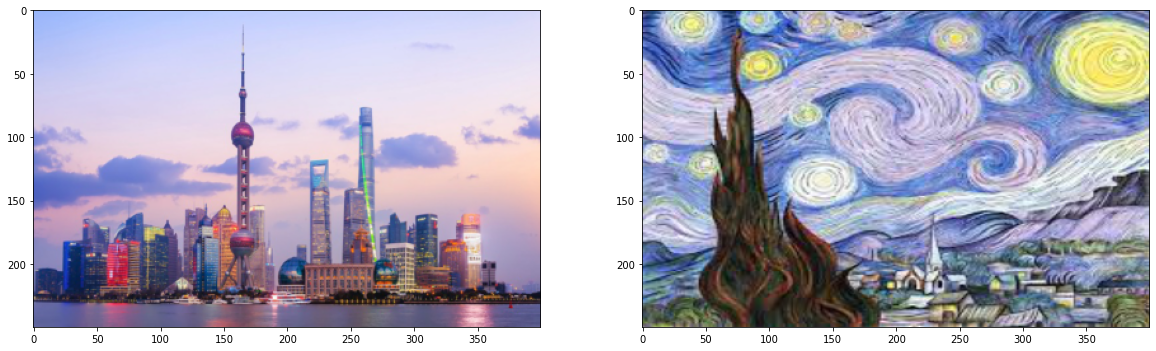

In [12]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

In [13]:
# Get the features through some layers (where number of channels is changing) of the model 

def get_features(image, model, layers=None):

  if layers is None:
    layers = { '0' : 'conv1_1',
               '5':  'conv2_1',
               '10': 'conv3_1',
               '19': 'conv4_1',
               '21': 'conv4_2', # conteny representation
               '28': 'conv5_1'}

    features = {}
    x = image    
    # model._modules is a dictionary which holds each module in the model
    for name, layer in model._modules.items():
      x = layer(x)
      if name in layers:
        features[layers[name]] = x

    return features    

In [14]:
# calculating the gram matrix for a given tensor
def gram_matrix(tensor):
  b, d, h, w = tensor.size()
  # reshaping so that we are multiplying the features for each channel
  tensor = tensor.view(b*d, h*w)
  # calculating the gram matrix
  gram = torch.mm(tensor, tensor.t())

  return gram

In [16]:
# getting content and style features from respective images
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculating the gram matrix for each layer of the style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# creating a 'target' image 
# starting target as a copy of the content image, then change it's style iteratively
# clone() makes an exact copy of the given image
target = content.clone().requires_grad_(True).to(device)

Weighing the style representation at each layer.
It's generally recommended to use a range between 0-1 to weight these layers.
Weighing earlier layers (conv1_1 and conv2_1) more would lead to larger style artifacts in the resulting target image.
If more emphasis on smaller features is required, give more weights to the later layers.
This is because each layer has a different size and together they create a multi-scale representation.

alpha is the content_weight 
beta is the style_weight
The ratio of alpha to beta affects how stylized the final image is.
usually, the content_weight is set tp 1 and style_weight is fiddled with to achieve the required ratio.

In [17]:

style_weights = { 'conv1_1': 1,
                  'conv2_1': 0.75,
                  'conv3_1': 0.2,
                  'conv4_1': 0.2,
                  'conv5_1': 0.2    
}

content_weight = 1 #alpha
style_weight = 1e6 #beta

Total loss 3223213.25


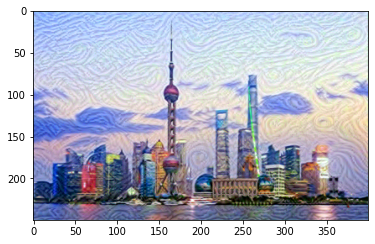

Total loss 1531188.375


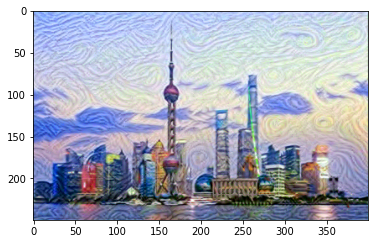

Total loss 930053.875


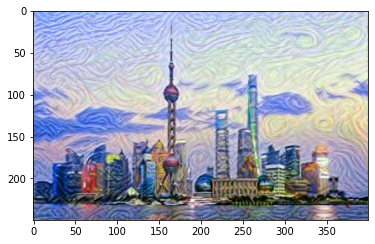

Total loss 619197.3125


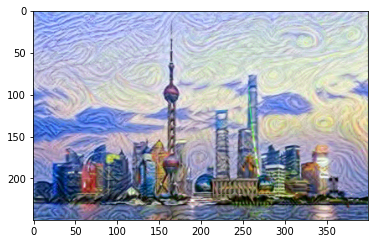

Total loss 437854.96875


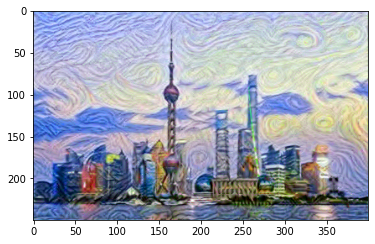

In [18]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000 # number of iterations to update the image for 

for i in range(1, steps+1):

  # getting features from the target image
  target_features = get_features(target, vgg)

  # content loss
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

  # style loss
  # initializing the style loss to zer
  style_loss = 0
  # then adding to it the loss of each layer's gram matrix
  for layer in style_weights:
    #getting the 'target' style representation for the layer
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    b, d, h, w = target_feature.shape
    # getting the style representation of 'style' image
    style_gram = style_grams[layer]
    # style loss for each layer, weighted appropriately
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    # add to the style loss
    style_loss += layer_style_loss / (d * h *w)  # normalizing the loss by the size of the layer

  # calculating the total loss
  total_loss = content_weight * content_loss + style_weight * style_loss

  # updating the target image
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  # displaying intermediate images and printing the loss
  if i % show_every == 0:
    print('Total loss', total_loss.item())
    plt.imshow(im_convert(target))
    plt.show()


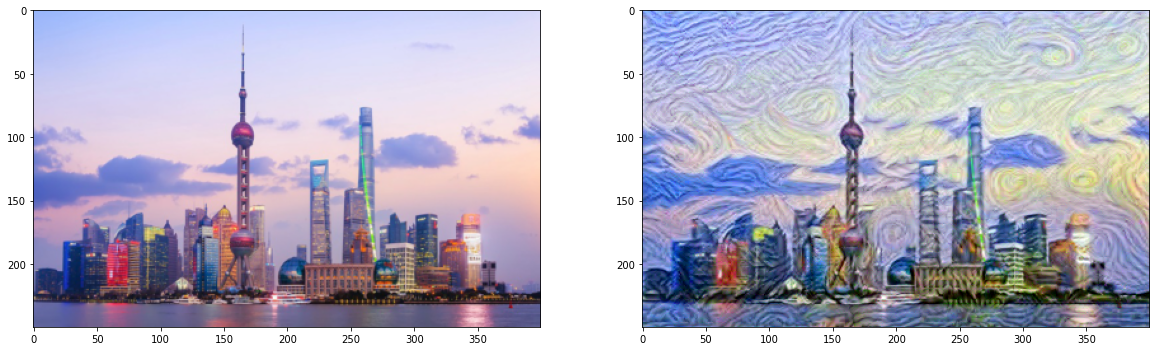

In [19]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))

In [20]:
# Reference: https://github.com/udacity/deep-learning-v2-pytorch/blob/master/style-transfer/Style_Transfer_Solution.ipynb